In [ ]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import xgboost as xgb

# Paths
BASE_DIR       = Path("/home/hajjohn1/bachelors-thesis")
TRAIN_PATH     = BASE_DIR / "data" / "training.parquet"       
EVAL_PATH      = BASE_DIR / "data" / "evaluation.parquet"   
TARGETS_PATH   = BASE_DIR / "data" / "target_channels.csv"    
MODEL_PATH     = BASE_DIR / "final" / "XGB" / "nolag_corrected" / "run_20250817_123404" / "xgb_model.json"
OUTPUT_DIR     = BASE_DIR / "final" / "XGB" / "nolag_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


def prune_correlated_features(df, feats, thresh=0.95):
    sample = df[feats] 
    corr = sample.corr().abs()
    mask = np.triu(np.ones_like(corr), k=1).astype(bool)
    high = corr.where(mask).stack().loc[lambda x: x > thresh].index
    to_drop = set(f2 for f1, f2 in high)
    pruned_feats = [f for f in feats if f not in to_drop]
    return pruned_feats

train_df     = pd.read_parquet(TRAIN_PATH)
targets      = pd.read_csv(TARGETS_PATH, header=None).iloc[:, 0].tolist()
train_feats  = [c for c in targets if c in train_df.columns]
selected_feats = prune_correlated_features(train_df, train_feats, thresh=0.95)
print(f"Using {len(selected_feats)} features after pruning.")

model = xgb.Booster()
model.load_model(str(MODEL_PATH))
model.feature_names = selected_feats


eval_df = pd.read_parquet(EVAL_PATH)


dmatrix = xgb.DMatrix(eval_df[selected_feats], feature_names=selected_feats)
probs   = model.predict(dmatrix)
preds   = (probs >= 0.5).astype(int)


mask      = eval_df['is_anomaly'] == 1  
event_ids = (mask != mask.shift(fill_value=False)).cumsum()
eval_df['event_id'] = np.where(mask, event_ids, np.nan)

events = []
for eid, group in eval_df[eval_df['event_id'].notna()].groupby('event_id'):
    length   = int(len(group))
    detected = bool(preds[group.index].sum() > 0)
    events.append({
        'event_id': int(eid),
        'length': length,
        'detected': detected
    })


model_name = Path(MODEL_PATH).stem
out_path    = OUTPUT_DIR / f"eval_event_detection_{model_name}.json"
with open(out_path, 'w') as f:
    json.dump({'model': model_name, 'events': events}, f, indent=2)

print(f"Saved {len(events)} event detection records to {out_path}")


Using 20 features after pruning.
Saved 53 event detection records to /home/hajjohn1/bachelors-thesis/final/XGB/eval_event_detection_xgb_model.json


/tmp/ipykernel_2117168/568569374.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("length_bin")["detected"]


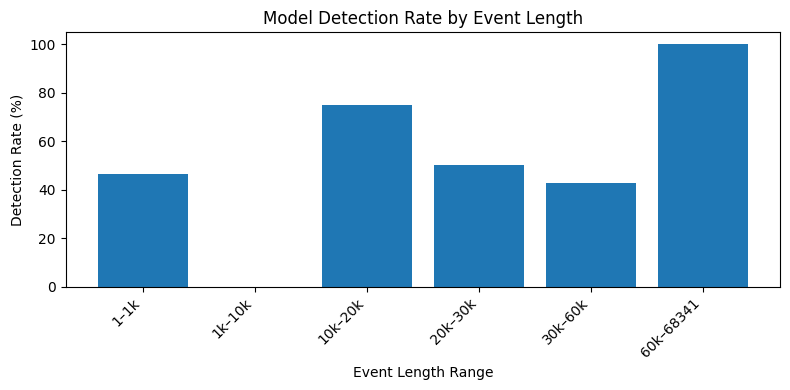

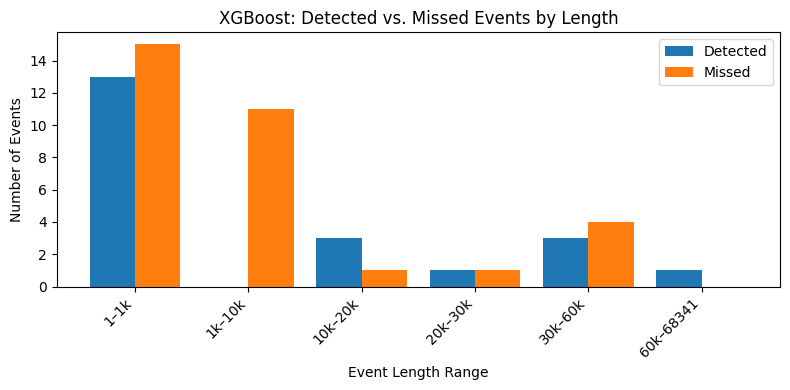

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df_events = pd.DataFrame(events)[["length", "detected"]]


max_len = df_events["length"].max()
bins = [1, 1_000, 10_000, 20_000, 30_000, 60_000, max_len + 1]
labels = ["1–1k", "1k–10k", "10k–20k", "20k–30k", "30k–60k", f"60k–{int(max_len)}"]


df_events["length_bin"] = pd.cut(
    df_events["length"],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)


grouped = (
    df_events
    .groupby("length_bin")["detected"]
    .agg(total_events="count", detected_events="sum")
)
grouped["detection_rate"] = grouped["detected_events"] / grouped["total_events"] * 100


plt.figure(figsize=(8, 4))
plt.bar(grouped.index, grouped["detection_rate"])
plt.xlabel("Event Length Range")
plt.ylabel("Detection Rate (%)")
plt.title("Model Detection Rate by Event Length")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


undetected = grouped["total_events"] - grouped["detected_events"]
x = np.arange(len(grouped.index))
width = 0.4

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, grouped["detected_events"], width, label="Detected")
plt.bar(x + width/2, undetected, width, label="Missed")
plt.xticks(x, grouped.index, rotation=45, ha="right")
plt.xlabel("Event Length Range")
plt.ylabel("Number of Events")
plt.title("XGBoost: Detected vs. Missed Events by Length")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
total_events = len(events)
detected_count = sum(e['detected'] for e in events)
print(f"Detected {detected_count} out of {total_events} events ({detected_count/total_events*100:.1f}%).")

Detected 21 out of 53 events (39.6%).


Using 20 features after pruning.
['channel_12', 'channel_14', 'channel_15', 'channel_16', 'channel_41', 'channel_43', 'channel_44', 'channel_47', 'channel_50', 'channel_57', '...']
Saved 137 training event detection records to /home/hajjohn1/bachelors-thesis/final/XGB/train_event_detection_xgb_model.json


/tmp/ipykernel_2117168/2698630123.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("length_bin", dropna=False)["detected"]


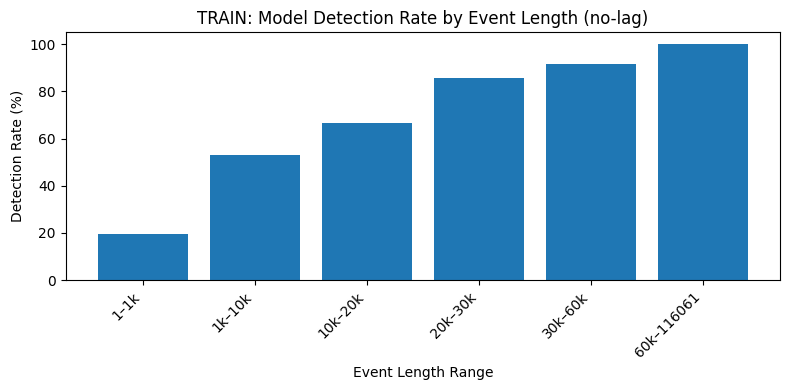

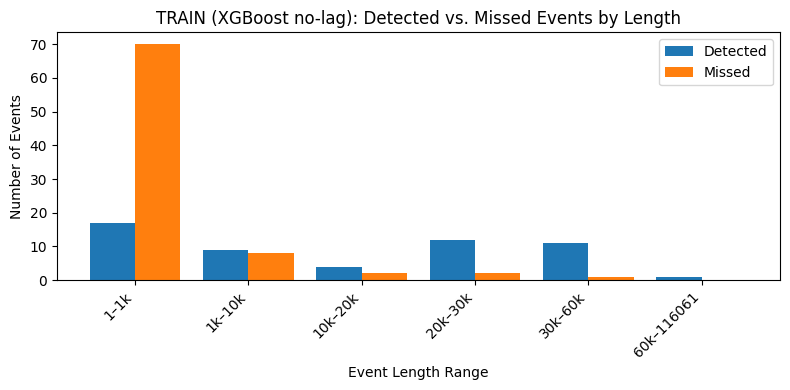

[TRAIN] Detected 54 out of 137 events (39.4%).


In [ ]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import xgboost as xgb
import matplotlib.pyplot as plt


BASE_DIR       = Path("/home/hajjohn1/bachelors-thesis")
TRAIN_PATH     = BASE_DIR / "data" / "training.parquet"      
TARGETS_PATH   = BASE_DIR / "data" / "target_channels.csv"   
MODEL_PATH     = BASE_DIR / "final" / "XGB" / "nolag_corrected" / "run_20250817_123404" / "xgb_model.json"
OUTPUT_DIR     = BASE_DIR / "final" / "XGB" / "nolag_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def prune_correlated_features(df, feats, thresh=0.95):
    sample = df[feats]
    corr = sample.corr().abs()
    mask = np.triu(np.ones_like(corr), k=1).astype(bool)
    high = corr.where(mask).stack().loc[lambda x: x > thresh].index
    to_drop = set(f2 for f1, f2 in high)
    pruned_feats = [f for f in feats if f not in to_drop]
    return pruned_feats

train_df = pd.read_parquet(TRAIN_PATH)

if "is_anomaly" not in train_df.columns:
    raise ValueError("Label column 'is_anomaly' missing in training.parquet")

targets = pd.read_csv(TARGETS_PATH, header=None).iloc[:, 0].tolist()
train_feats = [c for c in targets if c in train_df.columns and c != "is_anomaly"]
selected_feats = prune_correlated_features(train_df, train_feats, thresh=0.95)

if len(selected_feats) == 0:
    raise ValueError("No selected features found after pruning. Check TARGETS_PATH and input data.")

print(f"Using {len(selected_feats)} features after pruning.")
print(selected_feats[:10] + (['...'] if len(selected_feats) > 10 else []))

model = xgb.Booster()
model.load_model(str(MODEL_PATH))

dmatrix_train = xgb.DMatrix(train_df[selected_feats], feature_names=selected_feats)
probs_train   = model.predict(dmatrix_train)
preds_train   = (probs_train >= 0.5).astype(int)

mask = train_df['is_anomaly'] == 1
event_ids = (mask != mask.shift(fill_value=False)).cumsum()
train_df['event_id'] = np.where(mask, event_ids, np.nan)

events = []
for eid, group in train_df[train_df['event_id'].notna()].groupby('event_id'):
    length   = int(len(group))
    detected = bool(preds_train[group.index].sum() > 0)  # any positive within event window
    events.append({
        'event_id': int(eid),
        'length': length,
        'detected': detected
    })


model_name = Path(MODEL_PATH).stem
out_path   = OUTPUT_DIR / f"train_event_detection_{model_name}.json"
with open(out_path, 'w') as f:
    json.dump({'model': model_name, 'split': 'train', 'events': events}, f, indent=2)

print(f"Saved {len(events)} training event detection records to {out_path}")


if len(events) == 0:
    print("No events found in training labels (is_anomaly == 1). Skipping plots.")
else:
    df_events = pd.DataFrame(events)[["length", "detected"]]

    max_len = int(df_events["length"].max())
    bins = [1, 1_000, 10_000, 20_000, 30_000, 60_000, max_len + 1]
    labels = ["1–1k", "1k–10k", "10k–20k", "20k–30k", "30k–60k", f"60k–{max_len}"]

    df_events["length_bin"] = pd.cut(
        df_events["length"],
        bins=bins,
        labels=labels,
        right=False,
        include_lowest=True
    )

    grouped = (
        df_events
        .groupby("length_bin", dropna=False)["detected"]
        .agg(total_events="count", detected_events="sum")
    )

    grouped["detection_rate"] = np.where(
        grouped["total_events"] > 0,
        grouped["detected_events"] / grouped["total_events"] * 100.0,
        0.0
    )

    plt.figure(figsize=(8, 4))
    plt.bar(grouped.index.astype(str), grouped["detection_rate"])
    plt.xlabel("Event Length Range")
    plt.ylabel("Detection Rate (%)")
    plt.title("TRAIN: Model Detection Rate by Event Length (no-lag)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    undetected = grouped["total_events"] - grouped["detected_events"]
    x = np.arange(len(grouped.index))
    width = 0.4

    plt.figure(figsize=(8, 4))
    plt.bar(x - width/2, grouped["detected_events"], width, label="Detected")
    plt.bar(x + width/2, undetected, width, label="Missed")
    plt.xticks(x, grouped.index.astype(str), rotation=45, ha="right")
    plt.xlabel("Event Length Range")
    plt.ylabel("Number of Events")
    plt.title("TRAIN (XGBoost no-lag): Detected vs. Missed Events by Length")
    plt.legend()
    plt.tight_layout()
    plt.show()

    total_events = len(events)
    detected_count = int(grouped["detected_events"].sum())
    print(f"[TRAIN] Detected {detected_count} out of {total_events} events "
          f"({detected_count/total_events*100:.1f}%).")
